In [1]:
using Revise # Run this first, if you intend to develop the package

In [2]:
# unnecessary if you follow README
# using Pkg
# Pkg.activate("../QControl")
# Pkg.instantiate()

# Imports

In [3]:
using QControl

┌ Info: Precompiling QControl [edd81335-bcb3-4e33-9681-20bc820459a6]
└ @ Base loading.jl:1423


In [4]:
const QC = QControl;

In [5]:
using QuantumOptics
import PyPlot as plt
using Plots; pyplot()
using Altro
using ForwardDiff
using LinearAlgebra
using SparseArrays
using RobotDynamics
using TrajectoryOptimization
using StaticArrays
using ForwardDiff
using FiniteDiff
using JLD2
const TO = TrajectoryOptimization
const RD = RobotDynamics
;

# Single Qubit System

In [6]:
bq_single = SpinBasis(1//2)
H₀_single = 2*π*5*sigmaz(bq_single)/2
Hcs_single = [sigmax(bq_single)/2]
ψi_single = [spindown(bq_single), spinup(bq_single)]
ψt_single = [spinup(bq_single), spindown(bq_single)]
num_states = size(ψi_single)[1]
single_state_dim = 2*size(ψi_single[1])[1]
;

In [13]:
RD.state_dim(::QC.QuantumState), RD.control_dim(::QC.QuantumState), dynamics_func, ψi_state, ψt_state = QC.gen_LQR_params(bq_single, H₀_single, Hcs_single, ψi_single, ψt_single)
RD.dynamics(qs::QC.QuantumState,x,u) = dynamics_func(qs::QC.QuantumState,x,u)
;

In [15]:
model = QC.QuantumState()
state_dim = RD.state_dim(model)
control_dim = RD.control_dim(model)
obj = gen_default_objective(state_dim, control_dim, ψt_state; N=1001, tf=10.0, R_scale=0.0001)

Objective

In [10]:
cons = ConstraintList(state_dim, control_dim, N)

# norm constraints
for i=1:num_states
    indexs = Vector(single_state_dim*(i-1)+1:single_state_dim*i)
    print(indexs)
    normcon = NormConstraint(state_dim, control_dim, 1.0, Equality(), indexs)
    add_constraint!(cons, normcon, N)
end

# target state constraint
goalcon = GoalConstraint(ψt_state)
add_constraint!(cons, goalcon, N)

[1, 2, 3, 4][5, 6, 7, 8]

In [11]:
prob = Problem(model, obj, ψi_state, tf, xf=ψt_state, integration=RD.RK4(model), constraints=cons);

In [12]:
initial_controls!(prob, [@SVector rand(control_dim) for k = 1:N-1])
rollout!(prob)   # simulate the system forward in time with the new controls

In [13]:
# Set up solver options
opts = SolverOptions()
opts.cost_tolerance = 1e-8

# Create a solver, adding in additional options
solver = ALTROSolver(prob, opts, show_summary=false);

In [14]:
solve!(solver);

In [15]:
status(solver)

NO_PROGRESS::TerminationStatus = 8

In [83]:
println("Number of iterations: ", iterations(solver))
println("Final cost: ", cost(solver))
println("Final constraint satisfaction: ", max_violation(solver)) #TODO: is 1 good??

Number of iterations: 212
Final cost: 53046.90824387578
Final constraint satisfaction: 31.057127748026964


In [84]:
X = states(solver)     # alternatively states(prob)
U = controls(solver)   # alternatively controls(prob)
Xv = Vector.(X)
Uv = Vector.(U)
Ucv = QC.real_to_complex_isomorphism.(Uv)
Urv = map(cv -> real(cv)[1], Ucv)
Uiv = map(cv -> imag(cv)[1], Ucv)
Uav = map(cv -> norm(cv)[1], Ucv)
;

In [85]:
Xqv = map(x -> map(y -> normalize(Ket(bq_single, QC.real_to_complex_isomorphism(y))), split_state(x, 4, 2)), Xv)
;

In [86]:
println(Xqv[1][1])
println(Xqv[end][1])

Ket(dim=2)
  basis: Spin(1/2)
 0.0 + 0.0im
 1.0 + 0.0im
Ket(dim=2)
  basis: Spin(1/2)
 0.38771969999356626 + 0.1202930599747858im
  0.8547081631277874 + 0.323538204608861im


In [87]:
println(Xqv[1][2])
println(Xqv[end][2])

Ket(dim=2)
  basis: Spin(1/2)
 1.0 + 0.0im
 0.0 + 0.0im
Ket(dim=2)
  basis: Spin(1/2)
 -0.3224771547888946 - 0.1879064337807336im
 -0.8231451524360733 - 0.42793891480450785im


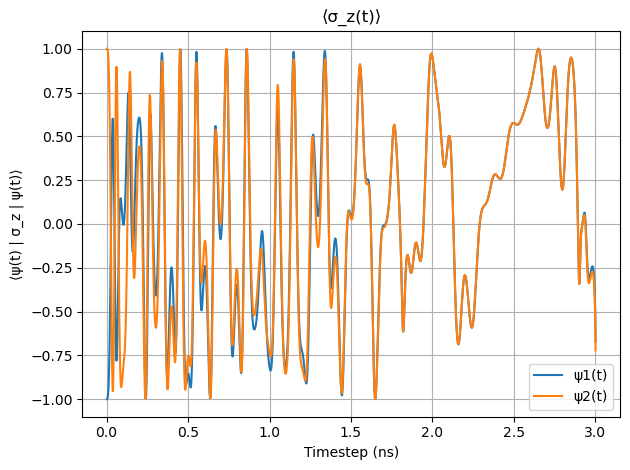

In [88]:
ts = 1:N
for i=1:num_states
    szt = map(qv -> real(expect(sigmaz(bq_single),qv[i])), Xqv);
    plot(dt*ts, szt, label= string("ψ", i, "(t)"))
end
xlabel("Timestep (ns)")
ylabel("⟨ψ(t) | σ_z | ψ(t)⟩")
title("⟨σ_z(t)⟩")
grid("on")
legend()
tight_layout()

# 3ns * 1.2 = pi

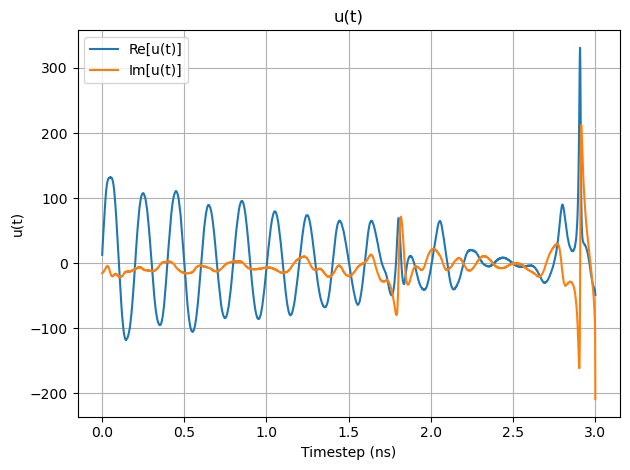

In [89]:
ts = 1:N-1
xlabel("Timestep (ns)")
ylabel("u(t)")
title("u(t)")
plot(dt*ts, Urv, label="Re[u(t)]")
plot(dt*ts, Uiv, label="Im[u(t)]")
# plot(dt*ts, Uav, label="|u(t)|")
grid("on")
legend()
tight_layout()

# References

[1] https://arxiv.org/pdf/1707.01060.pdf (quantum optics)

[2] https://github.com/alec-eickbusch/QOGS (quantum optimal gate synthesis)

[3] https://arxiv.org/pdf/2103.15716.pdf  (robotic quantum optimal control)

[4] https://journals.aps.org/prx/pdf/10.1103/PhysRevX.6.031006 (binomial code)